In [1]:
# Cell 1: Install & Import Libraries

# Install kagglehub if not already installed (usually pre-installed in Kaggle notebooks)
!pip install kagglehub

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # For nice progress bars in notebooks

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Cell 2: Download Dataset from KaggleHub (FIXED)

import kagglehub
import os

# Download latest version of the dataset
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

# Set the base DATA_DIR to the downloaded dataset path
DATA_DIR = path

# Correct the paths based on the observed Kaggle structure
# styles.csv is typically directly under 'fashion-product-images-dataset/styles.csv' OR 'fashion-product-images-dataset/fashion-dataset/styles.csv'
# images are typically directly under 'fashion-product-images-dataset/images' OR 'fashion-product-images-dataset/fashion-dataset/images'

# Let's inspect the downloaded path to confirm the structure
# You can uncomment the following lines to explore the directory structure if needed
# print(f"Contents of {DATA_DIR}: {os.listdir(DATA_DIR)}")
# if os.path.exists(os.path.join(DATA_DIR, 'fashion-dataset')):
#     print(f"Contents of {os.path.join(DATA_DIR, 'fashion-dataset')}: {os.listdir(os.path.join(DATA_DIR, 'fashion-dataset'))}")


# Based on your previous output, it seems 'styles.csv' is in 'fashion-dataset'
# and thus, 'images' should also be in 'fashion-dataset'.
# This is the most common structure for this dataset on Kaggle.

# Adjusting paths to point inside the 'fashion-dataset' subdirectory
NESTED_DIR = os.path.join(DATA_DIR, 'fashion-dataset')
IMAGE_FOLDER = os.path.join(NESTED_DIR, 'images')
CSV_PATH = os.path.join(NESTED_DIR, 'styles.csv')


print(f"Dataset downloaded to base: {DATA_DIR}")
print(f"Path to nested directory: {NESTED_DIR}")
print(f"Corrected Path to images folder: {IMAGE_FOLDER}")
print(f"Corrected Path to styles.csv: {CSV_PATH}")

# Verify if the corrected paths exist
if not os.path.exists(IMAGE_FOLDER):
    print(f"Error: Image folder NOT found at {IMAGE_FOLDER}. Please double check the exact path on Kaggle.")
    # Fallback/Debug: Try the other common path if the first doesn't work
    print("Attempting to find images directly under DATA_DIR for debugging...")
    IMAGE_FOLDER = os.path.join(DATA_DIR, 'images')
    CSV_PATH = os.path.join(DATA_DIR, 'styles.csv')
    print(f"Debug Path to images folder: {IMAGE_FOLDER}")
    print(f"Debug Path to styles.csv: {CSV_PATH}")
    if not os.path.exists(IMAGE_FOLDER):
         print(f"Still Error: Debug Image folder NOT found at {IMAGE_FOLDER}.")
         print("Please manually inspect the dataset directory structure in the Kaggle UI.")
    else:
        print("Found images in direct DATA_DIR. Using debug paths.")


if not os.path.exists(CSV_PATH):
    print(f"Error: styles.csv NOT found at {CSV_PATH}. Please double check the exact path on Kaggle.")
    # Fallback/Debug: Try the other common path if the first doesn't work
    CSV_PATH = os.path.join(DATA_DIR, 'styles.csv')
    print(f"Debug Path to styles.csv: {CSV_PATH}")
    if not os.path.exists(CSV_PATH):
        print(f"Still Error: Debug styles.csv NOT found at {CSV_PATH}.")
        print("Please manually inspect the dataset directory structure in the Kaggle UI.")
    else:
        print("Found styles.csv in direct DATA_DIR. Using debug paths.")

Dataset downloaded to base: /kaggle/input/fashion-product-images-dataset
Path to nested directory: /kaggle/input/fashion-product-images-dataset/fashion-dataset
Corrected Path to images folder: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
Corrected Path to styles.csv: /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv


In [3]:
# Cell 3: Configuration Parameters

BATCH_SIZE = 64
NUM_EPOCHS = 5 # Increased epochs slightly for potentially better performance
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_SAVE_PATH = 'best_article_type_classifier.pth'

print(f"Using device: {DEVICE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")

Using device: cuda
Batch Size: 64
Number of Epochs: 5
Learning Rate: 0.001
Model will be saved to: best_article_type_classifier.pth


In [4]:
# Cell 4: Load and Clean Dataset

print("Loading and cleaning dataset...")

try:
    # Use on_bad_lines='skip' to handle potential parsing errors in CSV
    df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Please ensure 'styles.csv' is in the specified DATA_DIR.")
    exit()

# Drop rows with missing values in crucial columns for classification and metadata
initial_rows = len(df)
df.dropna(subset=['id', 'articleType', 'baseColour', 'gender'], inplace=True)
print(f"Rows after dropping NaNs: {len(df)} (Dropped {initial_rows - len(df)} rows)")

# Convert 'id' to string for consistent comparison with image filenames
df['id'] = df['id'].astype(str)

# Filter out rows where image files do not exist
print(f"Scanning image folder: {IMAGE_FOLDER}...")
# Get only the base name (e.g., '10001' from '10001.jpg')
existing_images = set(img.split('.')[0] for img in os.listdir(IMAGE_FOLDER) if img.endswith('.jpg'))
print(f"Found {len(existing_images)} existing image files.")

filtered_df = df[df['id'].isin(existing_images)].copy()

print(f"Original DataFrame size: {len(df)}")
print(f"Filtered DataFrame size (after checking image existence): {len(filtered_df)}")
print(f"Removed {len(df) - len(filtered_df)} rows due to missing images.")


if filtered_df.empty:
    print("No valid images found after filtering. Please check your image folder and CSV.")
    # You might want to halt execution or raise an error here if no data remains
else:
    print("Dataset loaded and cleaned successfully!")
    print(f"Sample data after cleaning:\n{filtered_df.head()}")

# Preserve original metadata for later use
# This DataFrame contains id, baseColour, and gender for all valid images
metadata_df = filtered_df[['id', 'baseColour', 'gender']].copy()
print(f"Metadata DataFrame created with {len(metadata_df)} entries.")

Loading and cleaning dataset...
Rows after dropping NaNs: 44409 (Dropped 15 rows)
Scanning image folder: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images...
Found 44441 existing image files.
Original DataFrame size: 44409
Filtered DataFrame size (after checking image existence): 44404
Removed 5 rows due to missing images.
Dataset loaded and cleaned successfully!
Sample data after cleaning:
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Nav

In [5]:
# Cell 5: Label Encoding and Stratified Data Split (FIXED for single-sample classes)

print("Encoding labels and splitting data...")

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'articleType' column to numerical labels
# Applying label encoding early to count class occurrences
filtered_df['label'] = le.fit_transform(filtered_df['articleType'])

# --- NEW ADDITION: Handle single-sample classes for stratified split ---
print("Checking for and handling single-sample classes...")
class_counts = filtered_df['label'].value_counts()
single_sample_classes = class_counts[class_counts < 2].index

if not single_sample_classes.empty:
    print(f"Found {len(single_sample_classes)} article types with only 1 sample. Removing these for stratified split.")
    
    # Get the actual articleType names for these single-sample labels
    single_sample_article_types = le.inverse_transform(single_sample_classes)
    print(f"Single-sample article types being removed: {list(single_sample_article_types)}")

    # Filter out rows corresponding to single-sample classes
    initial_filtered_df_size = len(filtered_df)
    filtered_df = filtered_df[~filtered_df['label'].isin(single_sample_classes)].copy()
    print(f"Removed {initial_filtered_df_size - len(filtered_df)} rows due to single-sample classes.")
    
    # Re-fit LabelEncoder because we've removed some classes
    # This ensures labels are re-mapped contiguously from 0 to num_new_classes - 1
    # and `num_classes` correctly reflects the number of classes remaining.
    filtered_df['label'] = le.fit_transform(filtered_df['articleType'])
    print("LabelEncoder re-fitted after removing single-sample classes.")

# Verify label encoding (after potential re-fitting)
num_classes = len(le.classes_)
assert filtered_df['label'].min() == 0, "Labels do not start from 0 after re-fitting"
assert filtered_df['label'].max() == num_classes - 1, "Labels do not end at num_classes - 1 after re-fitting"
print(f"Number of unique article types (classes) after handling single-sample ones: {num_classes}")
print(f"Sample encoded labels:\n{filtered_df[['articleType', 'label']].drop_duplicates().sample(min(5, num_classes))}")


# Split data into train and validation sets using stratified sampling
train_df, val_df = train_test_split(
    filtered_df,
    test_size=0.2, # 20% for validation
    stratify=filtered_df['label'], # Stratify by the 'label' column
    random_state=42 # For reproducibility
)

print(f"Train DataFrame size: {len(train_df)}")
print(f"Validation DataFrame size: {len(val_df)}")
print("Data split complete!")

Encoding labels and splitting data...
Checking for and handling single-sample classes...
Found 6 article types with only 1 sample. Removing these for stratified split.
Single-sample article types being removed: ['Hair Accessory', 'Cushion Covers', 'Shoe Laces', 'Mens Grooming Kit', 'Body Wash and Scrub', 'Ipad']
Removed 6 rows due to single-sample classes.
LabelEncoder re-fitted after removing single-sample classes.
Number of unique article types (classes) after handling single-sample ones: 136
Sample encoded labels:
      articleType  label
11          Belts      7
92    Rain Jacket     87
574        Bangle      3
1421   Suspenders    111
140         Shrug    102
Train DataFrame size: 35518
Validation DataFrame size: 8880
Data split complete!


In [6]:
# Cell 6: PyTorch Custom Dataset Class (Revised for Memory Efficiency)

import os
from PIL import Image
import torch
from torch.utils.data import Dataset # Make sure Dataset is imported here

class FashionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        # Create a dictionary for faster lookup of image paths (id -> full_path)
        self.image_paths = {str(row['id']): os.path.join(image_dir, f"{row['id']}.jpg")
                            for index, row in dataframe.iterrows()}


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_id = str(row['id'])
        img_name = self.image_paths.get(img_id)

        if img_name is None:
            print(f"Error (FashionDataset): Image ID {img_id} path not found in pre-computed paths. Skipping.")
            return None # Return None if path not found

        try:
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)

            label = row['label']
            return image, label

        except FileNotFoundError:
            # This should ideally not happen after initial filtering in Cell 4
            print(f"Error (FashionDataset): Image file not found at {img_name}. ID: {img_id}. Skipping.")
            return None
        except Exception as e:
            # Catch ANY other exception during image loading/processing (e.g., corrupted image)
            print(f"Critical Error (FashionDataset) processing {img_name} (ID: {img_id}): {e}. Skipping.")
            return None

print("FashionDataset class defined (revised for memory efficiency).")

FashionDataset class defined (revised for memory efficiency).


In [7]:
# Cell 7: Data Transformations and DataLoaders (FIXED for Memory Exhaustion)

from torchvision import transforms # Make sure transforms is imported here
import torch
from torch.utils.data import DataLoader # Make sure DataLoader is imported here
from tqdm.notebook import tqdm # Keep tqdm if you want progress for later, but it's not used in the filtering list anymore

# Define image transformations for training and validation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 pixels
    transforms.ToTensor(),         # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

print("Creating FashionDataset instances...")
train_dataset = FashionDataset(train_df, IMAGE_FOLDER, transform=data_transforms)
val_dataset = FashionDataset(val_df, IMAGE_FOLDER, transform=data_transforms)
print("FashionDataset instances created.")

# --- CUSTOM COLLATING FUNCTION TO HANDLE NONE VALUES ---
def custom_collate_fn(batch):
    # Filter out None values from the batch
    batch = [item for item in batch if item is not None]

    if not batch: # If the entire batch became None, return empty tensors
        return torch.empty(0), torch.empty(0)

    # Default collate behavior for the rest of the batch
    return torch.utils.data.dataloader.default_collate(batch)

# --- CRUCIAL CHANGE: REMOVED THE [item for item in dataset if item is not None] LISTS ---
# DataLoaders will now directly use train_dataset and val_dataset.
# The `custom_collate_fn` handles any `None` values returned by __getitem__.

# Determine optimal num_workers for your environment
# Starting with 4, as it's typically a good balance. If hangs persist, try 2 or 0.
num_workers_to_use = 4

print("Creating DataLoaders...")
train_loader = DataLoader(
    train_dataset, # Directly use the dataset, no prior full list creation
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers_to_use,
    pin_memory=True,
    collate_fn=custom_collate_fn # Use our custom collate function
)
val_loader = DataLoader(
    val_dataset, # Directly use the dataset
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers_to_use,
    pin_memory=True,
    collate_fn=custom_collate_fn # Use our custom collate function
)

print(f"Train Dataset size (original): {len(train_dataset)}")
print(f"Validation Dataset size (original): {len(val_dataset)}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
print(f"Using {num_workers_to_use} num_workers for DataLoaders.")
print("DataLoaders created!")

Creating FashionDataset instances...
FashionDataset instances created.
Creating DataLoaders...
Train Dataset size (original): 35518
Validation Dataset size (original): 8880
Number of batches in training loader: 555
Number of batches in validation loader: 139
Using 4 num_workers for DataLoaders.
DataLoaders created!


In [8]:
# Cell 8: Model Definition (ResNet18)

print("Initializing ResNet18 model...")

# Load a pre-trained ResNet18 model
# ResNet18_Weights.DEFAULT uses the best available weights (ImageNet)
model = resnet18(weights=ResNet18_Weights.DEFAULT)

# Get the number of input features of the last fully connected layer
num_ftrs = model.fc.in_features

# Replace the original final layer with a new one that matches our number of classes
# This adapts the pre-trained model for our specific classification task
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the specified device (GPU or CPU)
model.to(DEVICE)

print(f"ResNet18 model initialized and moved to {DEVICE}.")
print(f"Final layer (model.fc) changed to: {model.fc}")

Initializing ResNet18 model...


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s] 


ResNet18 model initialized and moved to cuda.
Final layer (model.fc) changed to: Linear(in_features=512, out_features=136, bias=True)


In [9]:
# Cell 9: Training Loop (REVISED to explicitly define save paths)

import torch
import torch.nn as nn
import joblib # Needed for saving LabelEncoder
from tqdm.notebook import tqdm # Assuming you're using this for progress bars

print("Starting training...")

# --- Define Model Save Paths EXPLICITLY here ---
MODEL_SAVE_PATH = "best_article_type_classifier.pth"
LABEL_ENCODER_SAVE_PATH = "label_encoder.joblib"
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print(f"LabelEncoder will be saved to: {LABEL_ENCODER_SAVE_PATH}")
# --- End of explicit path definitions ---

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer

best_val_accuracy = 0.0 # To keep track of the best model performance

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Use tqdm for a progress bar
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Train)"):
        images, labels = images.to(DEVICE), labels.to(DEVICE) # Move data to device

        optimizer.zero_grad() # Clear gradients from previous iteration
        outputs = model(images) # Forward pass
        loss = criterion(outputs, labels) # Calculate loss
        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters

        running_loss += loss.item() * images.size(0) # Aggregate loss
        _, predicted = torch.max(outputs.data, 1) # Get the predicted class
        total_predictions += labels.size(0) # Total samples processed
        correct_predictions += (predicted == labels).sum().item() # Correct predictions

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

    # --- Validation Phase ---
    model.eval() # Set model to evaluation mode
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad(): # Disable gradient calculations during validation
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Validation)"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = val_correct_predictions / val_total_predictions
    print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH} with improved validation accuracy: {best_val_accuracy:.4f}")

# --- After the training loop completes, save the final LabelEncoder ---
# This ensures `le` is saved regardless of validation accuracy improvements
try:
    if 'le' in locals() or 'le' in globals(): # Check if 'le' exists
        joblib.dump(le, LABEL_ENCODER_SAVE_PATH)
        print(f"LabelEncoder saved to: {LABEL_ENCODER_SAVE_PATH}")
    else:
        print("Warning: LabelEncoder variable 'le' not found, skipping save.")
except Exception as e:
    print(f"Error saving LabelEncoder: {e}")


print("Training complete!")

Starting training...
Model will be saved to: best_article_type_classifier.pth
LabelEncoder will be saved to: label_encoder.joblib


Epoch 1/5 (Train):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 0.7935, Train Accuracy: 0.7810


Epoch 1/5 (Validation):   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 1 - Val Loss: 0.6402, Val Accuracy: 0.8036
Model saved to best_article_type_classifier.pth with improved validation accuracy: 0.8036


Epoch 2/5 (Train):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 0.4624, Train Accuracy: 0.8539


Epoch 2/5 (Validation):   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 2 - Val Loss: 0.5274, Val Accuracy: 0.8331
Model saved to best_article_type_classifier.pth with improved validation accuracy: 0.8331


Epoch 3/5 (Train):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.3542, Train Accuracy: 0.8849


Epoch 3/5 (Validation):   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 3 - Val Loss: 0.4797, Val Accuracy: 0.8557
Model saved to best_article_type_classifier.pth with improved validation accuracy: 0.8557


Epoch 4/5 (Train):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.2861, Train Accuracy: 0.9051


Epoch 4/5 (Validation):   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 4 - Val Loss: 0.4205, Val Accuracy: 0.8700
Model saved to best_article_type_classifier.pth with improved validation accuracy: 0.8700


Epoch 5/5 (Train):   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.2180, Train Accuracy: 0.9268


Epoch 5/5 (Validation):   0%|          | 0/139 [00:00<?, ?it/s]

Epoch 5 - Val Loss: 0.4508, Val Accuracy: 0.8682
LabelEncoder saved to: label_encoder.joblib
Training complete!


In [24]:
# Cell 10: Define Image Transformations for Inference

import torch.nn as nn # Ensure nn is imported if not already from previous cells
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt # For displaying images

# These transformations must be the SAME as used during training/validation
inference_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),          # Convert PIL Image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

print("Inference transformations defined.")

Inference transformations defined.


In [25]:
# Cell 11: Prediction Function

# Make sure model is in evaluation mode (it should be after Cell 9's validation phase, but good practice)
model.eval()

def predict_image(image_path, model, label_encoder, transforms, device):
    """
    Makes a prediction for a single image.

    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): The loaded PyTorch model.
        label_encoder (sklearn.preprocessing.LabelEncoder): The loaded LabelEncoder.
        transforms (torchvision.transforms.Compose): Image transformations for inference.
        device (torch.device): The device (CPU or GPU) to perform inference on.

    Returns:
        tuple: (predicted_label_str, confidence_float)
               Returns (None, None) if an error occurs.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image file not found at {image_path}")
        return None, None

    try:
        image = Image.open(image_path).convert('RGB')

        # Display the image (optional)
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.title("Input Image for Prediction")
        plt.axis('off')
        plt.show()

        image_tensor = transforms(image).unsqueeze(0) # Add batch dimension (1, C, H, W)
        image_tensor = image_tensor.to(device)

        with torch.no_grad(): # No need for gradients during inference
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1) # Convert logits to probabilities
            confidence, predicted_idx = torch.max(probabilities, 1) # Get max probability and its index

        predicted_label = label_encoder.inverse_transform(predicted_idx.cpu().numpy())[0]
        confidence_score = confidence.item()

        return predicted_label, confidence_score

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None, None

print("Prediction function defined.")

Prediction function defined.


Attempting prediction for: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10000.jpg


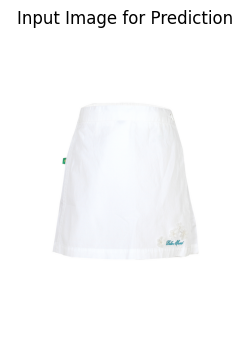


--- Prediction Result ---
Predicted Article Type: Skirts
Confidence: 0.9796


In [27]:
# Cell 12: Example Usage for a Single Image

# Ensure SAMPLE_IMAGE_BASE_PATH is set correctly in a prior cell if not here.
SAMPLE_IMAGE_BASE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

# Set your specific image path
SAMPLE_IMAGE_PATH = os.path.join(SAMPLE_IMAGE_BASE_PATH, "10000.jpg")

print(f"Attempting prediction for: {SAMPLE_IMAGE_PATH}")

# --- FIX: Changed 'model_loaded' to 'model' and added SAMPLE_IMAGE_PATH ---
predicted_type, confidence = predict_image(SAMPLE_IMAGE_PATH, model, le, inference_transforms, DEVICE)

if predicted_type is not None:
    print(f"\n--- Prediction Result ---")
    print(f"Predicted Article Type: {predicted_type}")
    print(f"Confidence: {confidence:.4f}")
else:
    print("Prediction failed.")

Found 44424 image IDs in /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv

Making predictions for 25 random images:

--- Prediction 1/25: Image ID 15249 ---


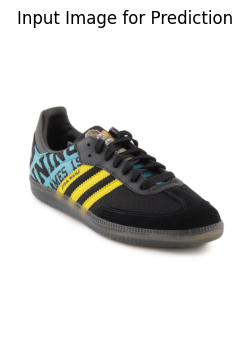

Predicted Article Type: Casual Shoes
Confidence: 0.7810

--- Prediction 2/25: Image ID 54017 ---


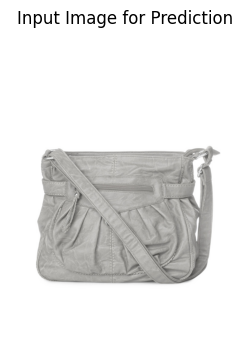

Predicted Article Type: Handbags
Confidence: 0.8592

--- Prediction 3/25: Image ID 41668 ---


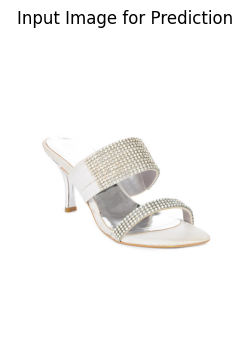

Predicted Article Type: Heels
Confidence: 0.9795

--- Prediction 4/25: Image ID 36381 ---


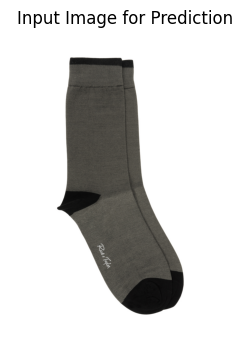

Predicted Article Type: Socks
Confidence: 0.9998

--- Prediction 5/25: Image ID 39253 ---


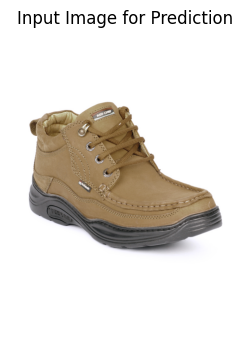

Predicted Article Type: Casual Shoes
Confidence: 0.9893

--- Prediction 6/25: Image ID 24179 ---


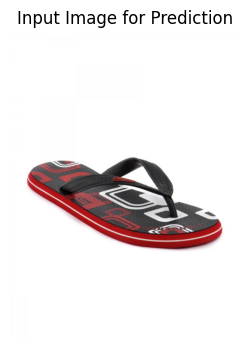

Predicted Article Type: Flip Flops
Confidence: 0.9766

--- Prediction 7/25: Image ID 7521 ---


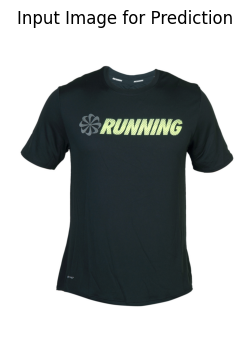

Predicted Article Type: Tshirts
Confidence: 0.9999

--- Prediction 8/25: Image ID 53035 ---


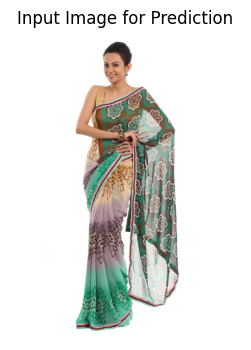

Predicted Article Type: Sarees
Confidence: 1.0000

--- Prediction 9/25: Image ID 15387 ---


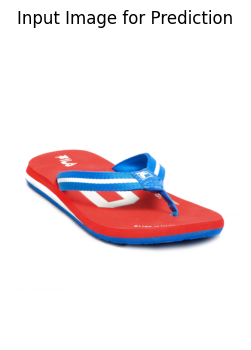

Predicted Article Type: Flip Flops
Confidence: 0.9998

--- Prediction 10/25: Image ID 12503 ---


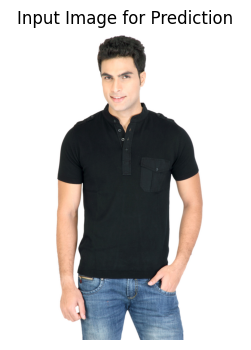

Predicted Article Type: Tshirts
Confidence: 0.9984

--- Prediction 11/25: Image ID 22730 ---


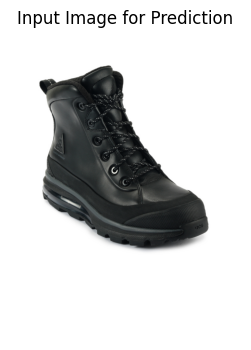

Predicted Article Type: Sports Shoes
Confidence: 0.6091

--- Prediction 12/25: Image ID 51554 ---


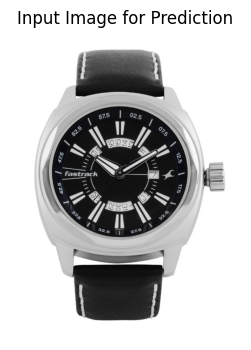

Predicted Article Type: Watches
Confidence: 0.9959

--- Prediction 13/25: Image ID 52603 ---


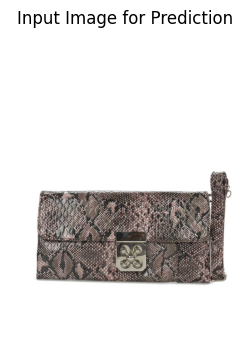

Predicted Article Type: Clutches
Confidence: 0.8231

--- Prediction 14/25: Image ID 54056 ---


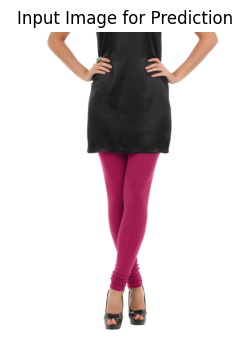

Predicted Article Type: Leggings
Confidence: 0.8684

--- Prediction 15/25: Image ID 33558 ---


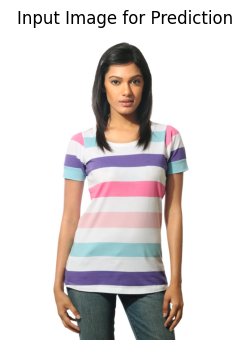

Predicted Article Type: Tshirts
Confidence: 0.9735

--- Prediction 16/25: Image ID 25790 ---


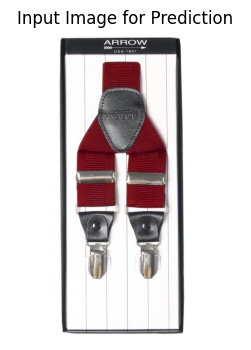

Predicted Article Type: Suspenders
Confidence: 0.9999

--- Prediction 17/25: Image ID 5124 ---


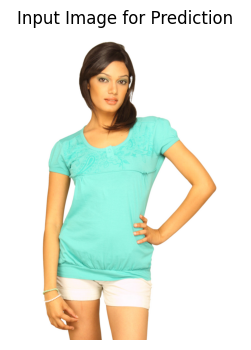

Predicted Article Type: Tshirts
Confidence: 0.9965

--- Prediction 18/25: Image ID 16551 ---


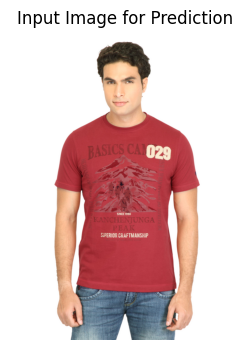

Predicted Article Type: Tshirts
Confidence: 0.9983

--- Prediction 19/25: Image ID 58011 ---


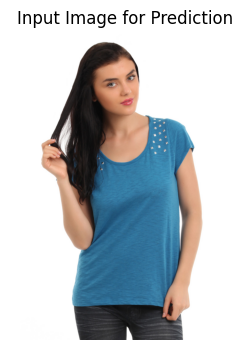

Predicted Article Type: Tops
Confidence: 0.8300

--- Prediction 20/25: Image ID 11614 ---


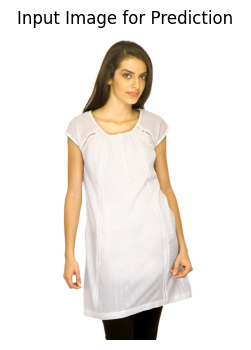

Predicted Article Type: Kurtas
Confidence: 0.9992

--- Prediction 21/25: Image ID 45214 ---


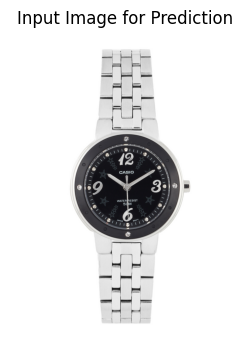

Predicted Article Type: Watches
Confidence: 0.9930

--- Prediction 22/25: Image ID 11900 ---


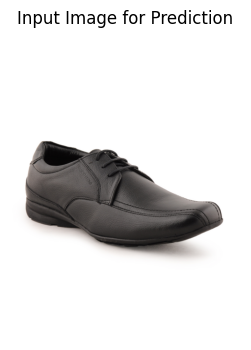

Predicted Article Type: Formal Shoes
Confidence: 0.9724

--- Prediction 23/25: Image ID 13435 ---


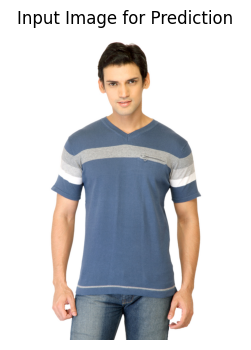

Predicted Article Type: Tshirts
Confidence: 0.9558

--- Prediction 24/25: Image ID 25385 ---


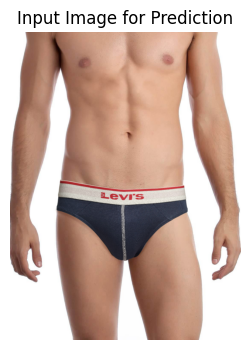

Predicted Article Type: Briefs
Confidence: 1.0000

--- Prediction 25/25: Image ID 54902 ---


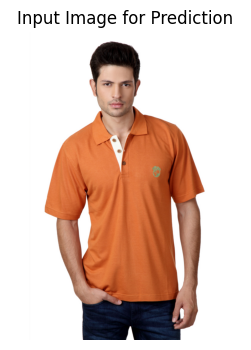

Predicted Article Type: Tshirts
Confidence: 0.8630

Finished predicting on random images.


In [29]:
# Cell 13: Predict on 25 Random Images

import pandas as pd
import random
import os # Ensure os is imported as it's used for path joining

# Path to the styles.csv
STYLES_CSV_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv"

# Load the styles.csv to get image IDs
try:
    # --- FIX: Using on_bad_lines='skip' to ignore malformed rows ---
    image_data = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip') # Corrected line
    # Ensure image_data contains an 'id' column that corresponds to image filenames (e.g., '1234.jpg')
    image_ids = image_data['id'].astype(str).tolist() # Convert IDs to string to match filenames like '1234.jpg'
    print(f"Found {len(image_ids)} image IDs in {STYLES_CSV_PATH}")
except Exception as e:
    print(f"Error loading styles.csv or extracting image IDs: {e}")
    image_ids = [] # Fallback to empty list if loading fails

if len(image_ids) == 0:
    print("No image IDs available. Cannot proceed with random predictions. (Check error above)")
else:
    # Ensure SAMPLE_IMAGE_BASE_PATH is defined (from Cell 12)
    # We'll re-define it here for robustness
    SAMPLE_IMAGE_BASE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"

    # Select 25 random image IDs
    num_predictions = 25
    random_image_ids = random.sample(image_ids, min(num_predictions, len(image_ids)))

    print(f"\nMaking predictions for {len(random_image_ids)} random images:")

    for i, img_id in enumerate(random_image_ids):
        # Construct the full image path using the corrected base path
        current_image_path = os.path.join(SAMPLE_IMAGE_BASE_PATH, f"{img_id}.jpg")
        print(f"\n--- Prediction {i+1}/{len(random_image_ids)}: Image ID {img_id} ---")

        predicted_type, confidence = predict_image(current_image_path, model, le, inference_transforms, DEVICE)

        if predicted_type is not None:
            print(f"Predicted Article Type: {predicted_type}")
            print(f"Confidence: {confidence:.4f}")
        else:
            print("Prediction failed for this image (check error messages above).")

print("\nFinished predicting on random images.")